# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import date

# Data Collection

In this exploratory data analysis we are going to be looking at the top 5 most played games on steam as of June 2022 which are Lost Ark, Counter-Strike, Dota 2, ARK, and Apex Legends. The data is going to be csv files that were downloaded from https://steamdb.info/graph/ and looking at the concurrent players over the course of the month of June 2022 to present day. 

It is important to consider the limitations and strengths of the data set that we are examining:

Pros:
- Exclusively records players from the Steam platform
- Records updated every 10 minutes
- Includes twitch views as an additional feature

Cons:
- Not all Players are included (i.e other platforms)
- Data limited to current week


In [2]:
# Data Collection

FILE_PATH = '../data/apex.csv'
df = pd.read_csv(FILE_PATH)

# Data Exploration

- Data Cleaning (Missing Data, Incorrect Datatype)
- Summary Statistics
- Correlation Matrix

In [3]:
df

,DateTime,Players,Players Trend,Twitch Viewers
0,2022-05-31 22:20:00,112300,177956.152778,96807
1,2022-05-31 22:30:00,111307,177912.427710,96756
2,2022-05-31 22:40:00,110563,177868.428131,98085
3,2022-05-31 22:50:00,110144,177825.616185,98080
4,2022-05-31 23:00:00,109717,177784.107016,99534
...,...,...,...,...
2011,2022-06-14 21:30:00,108148,161229.261770,69661
2012,2022-06-14 21:40:00,107093,161264.566413,68039
2013,2022-06-14 21:50:00,105766,161307.219453,69285
2014,2022-06-14 22:00:00,104124,161352.114239,77704


We will be handling any missing data. Drop the `Players Trend` column as it is the moving average provided by the Steamdb we will be creating our own player trend later on.

In [4]:
# Remove rows where there is no values for players
df.dropna(subset='Players', inplace=True)

# Removing flags column
df.drop(columns=['Players Trend'], inplace=True)

# Rename column names for convinence for later on when doing manipulations with dataframes.
df.columns = ['date', 'players', 'twitch_viewers']

df

,date,players,twitch_viewers
0,2022-05-31 22:20:00,112300,96807
1,2022-05-31 22:30:00,111307,96756
2,2022-05-31 22:40:00,110563,98085
3,2022-05-31 22:50:00,110144,98080
4,2022-05-31 23:00:00,109717,99534
...,...,...,...
2011,2022-06-14 21:30:00,108148,69661
2012,2022-06-14 21:40:00,107093,68039
2013,2022-06-14 21:50:00,105766,69285
2014,2022-06-14 22:00:00,104124,77704


Lets make sure that our columns have the correct datatypes. We can see that our date column is of type object indicating its being detected as a string when we really want it as a datetime.

In [5]:
# Checking to make sure that the dataframe has all the correct data types
df.dtypes

date              object
players            int64
twitch_viewers     int64
dtype: object

In [6]:
# Converting to first column to datateime
df.date = pd.to_datetime(df.date)

In [7]:
# Checkign to see that the date column is indeed a datetime rather than object
df.dtypes

date              datetime64[ns]
players                    int64
twitch_viewers             int64
dtype: object

In [8]:
# Check to make sure that the time interval is consistant

df['date_interval'] = df.date - df.shift(1).date

df.date_interval.unique()

array([       'NaT', 600000000000], dtype='timedelta64[ns]')

In [9]:
# Summary statistics of players (Peak # of Players, Lowest # of players, Average # of players)
df.players.describe()

count      2016.000000
mean     181867.052579
std       62838.757163
min       57704.000000
25%      134690.000000
50%      163271.000000
75%      219308.250000
max      344751.000000
Name: players, dtype: float64

Text(0.5, 1.0, '# of Players')

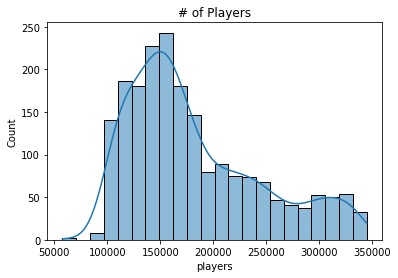

In [19]:
fig = sns.histplot(data=df.players, kde=True)
fig.set_title("# of Players")

In [11]:
# When was the largest decrease or increase of players
df['change_in_players'] = df.players - df.shift(1).players

# Making sure that change in players is an int and not a float
df.dropna(inplace=True)
df.change_in_players = df.change_in_players.astype(int)
df.change_in_players

1        -993
2        -744
3        -419
4        -427
5      -52013
        ...  
2011    -1929
2012    -1055
2013    -1327
2014    -1642
2015    -1818
Name: change_in_players, Length: 2015, dtype: int64

In [12]:
df.change_in_players.describe()


count     2015.000000
mean        -4.959801
std       4834.782676
min     -52013.000000
25%      -2165.500000
50%        239.000000
75%       2303.500000
max      27127.000000
Name: change_in_players, dtype: float64

Text(0.5, 1.0, 'Frequency Plot of Change in Players')

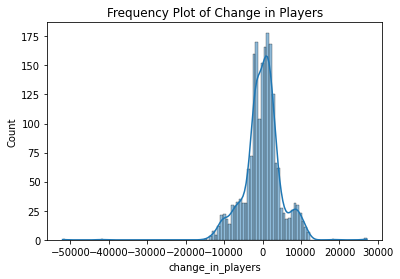

In [20]:
fig = sns.histplot(data=df.change_in_players, kde=True)
fig.set_title("Frequency Plot of Change in Players")


Text(0.5, 1.0, 'Correlation Matrix of Features')

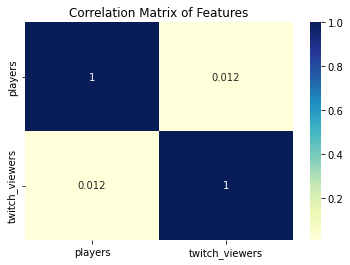

In [21]:
fig = sns.heatmap(df.iloc[:,:3].corr(), annot=True, cmap="YlGnBu")
fig.set_title("Correlation Matrix of Features")

There does not seem to be a correlation between players and twitch viewers and if there is it is a fairly weak correlation of 0.012.

In [15]:
# Simple Moving Average and variance
df['sma'] = df.players.rolling(window=48).mean()
df['std'] = df.players.rolling(window=48).var()
df

,date,players,twitch_viewers,date_interval,change_in_players,sma,std
1,2022-05-31 22:30:00,111307,96756,0 days 00:10:00,-993,NaN,NaN
2,2022-05-31 22:40:00,110563,98085,0 days 00:10:00,-744,NaN,NaN
3,2022-05-31 22:50:00,110144,98080,0 days 00:10:00,-419,NaN,NaN
4,2022-05-31 23:00:00,109717,99534,0 days 00:10:00,-427,NaN,NaN
5,2022-05-31 23:10:00,57704,94047,0 days 00:10:00,-52013,NaN,NaN
...,...,...,...,...,...,...,...
2011,2022-06-14 21:30:00,108148,69661,0 days 00:10:00,-1929,183542.083333,4.307946e+09
2012,2022-06-14 21:40:00,107093,68039,0 days 00:10:00,-1055,179489.854167,4.118980e+09
2013,2022-06-14 21:50:00,105766,69285,0 days 00:10:00,-1327,175384.583333,3.893792e+09
2014,2022-06-14 22:00:00,104124,77704,0 days 00:10:00,-1642,171254.437500,3.641319e+09


(19144.0, 19156.0)

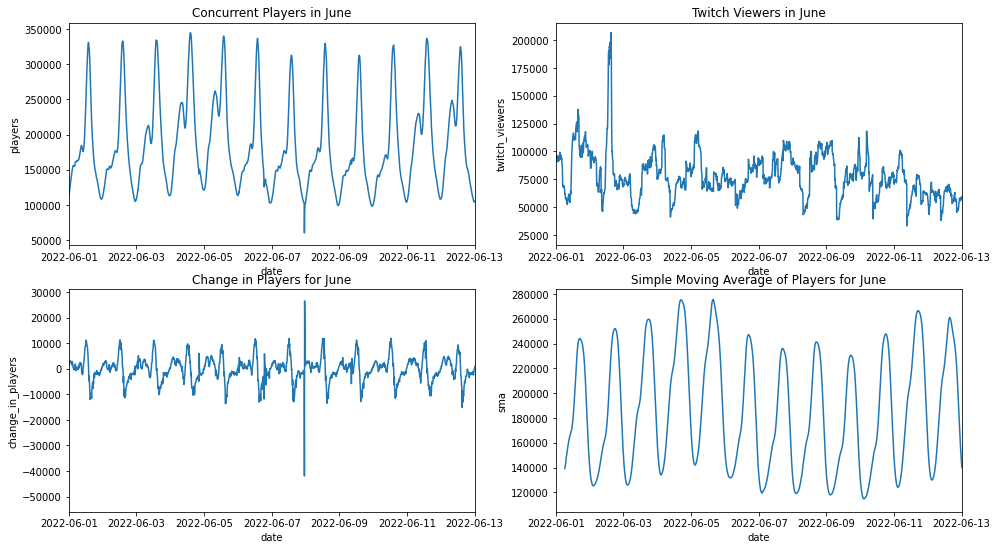

In [16]:
# Ploting


f, ax = plt.subplots(2,2,figsize=(16,9))

# Plotting columns
sns.lineplot(x=df.date, y=df.players, ax=ax[0,0])
sns.lineplot(x=df.date, y=df.twitch_viewers, ax=ax[0,1])
sns.lineplot(x=df.date, y=df.change_in_players, ax=ax[1,0])
sns.lineplot(x=df.date, y=df.sma, ax=ax[1,1])

ax[0,0].set_title("Concurrent Players in June")
ax[0,1].set_title("Twitch Viewers in June")
ax[1,0].set_title("Change in Players for June")
ax[1,1].set_title("Simple Moving Average of Players for June")

# Setting the x label axis to dates
ax[0,0].set_xlim([date(2022, 6, 1), date(2022, 6, 13)])
ax[0,1].set_xlim([date(2022, 6, 1), date(2022, 6, 13)])
ax[1,0].set_xlim([date(2022, 6, 1), date(2022, 6, 13)])
ax[1,1].set_xlim([date(2022, 6, 1), date(2022, 6, 13)])
